# Getting started with Hash antibody's

Cell Hashing is a method that enables sample multiplexing and super-loading on single cell RNA-sequencing platforms, developed in the Technology Innovation lab at the New York Genome Center in collaboration with the Satija lab.
Cell Hashing uses a series of oligo-tagged antibodies against ubiquitously expressed surface proteins with different barcodes to uniquely label cells from distinct samples, which can be subsequently pooled in one scRNA-seq run. By sequencing these tags alongside the cellular transcriptome, we can assign each cell to its sample of origin, and robustly identify doublets originating from multiple samples. [source](https://cite-seq.com/cell-hashing/), [Rahul-Satija](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-018-1603-1)

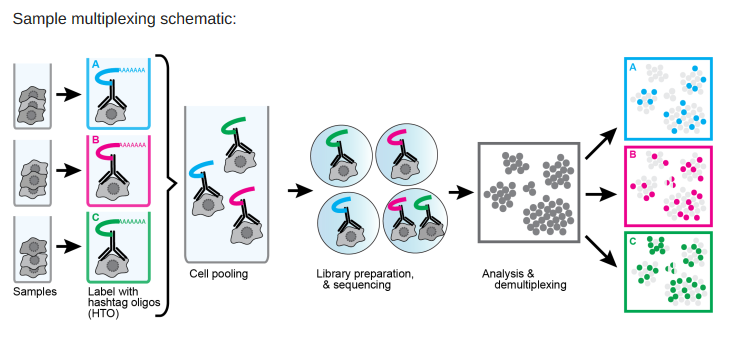


# Demultiplexing 

The demultiplexing is done by [CITE-seq](https://hoohm.github.io/CITE-seq-Count/) inside the pipeline.
To run CITE-seq-Count, as it is done in the pipeline, all Hash reads must have the same length. The Adapter trimming produces sometimes reads which have one base more so i trimmed them all to same length with fastx_trimmer to the standard length of 28bp. 

`
fastx_trimmer -z -l 28 -i Voss_Lib3_Hash_R2.fastq -o Voss_Lib3_Hash_R2_trim.fastq.gz
`

**CITE-seq-Count**
CITE-seq source "https://hoohm.github.io/CITE-seq-Count/" Instaltion `pip install CITE-seq-Count==1.4.4`

**Example**
`
CITE-seq-Count -R1  raw/Voss_Lib3_Hash_R1.fastq.gz -R2 raw/Voss_Lib3_Hash_R2_trim.fastq.gz --bc_collapsing_dist 2  -t reference_citeseq.csv -cells 0 -wl barcodes.tsv  -cbf 1 -cbl 16 -umif 17 -umil  28 --threads 16 --sliding-window
`

* -R1: Barcode file 
* -R2: Hash file 
* -cbf 1 : Start of Barcode
* -cbl 16 : End of Barcode
* -umif 17: start of umi
* -umil  28 end of umi 
* --bc_collapsing_dist 2  mistakes allowed in barcode (important set to two to get meaningful results lower values will produce low hash counts which cloud not be specified to a hash.)
* --sliding-window searches for best matching position of Hash. Need to be set as some hashes are not on fixed position. The hash reads start at bp 10 and are 15 bp long in normal.
* -wl barcodes whitelist comes from STARsolo demultiplexing.

**Output**
Citeseq creates two count matrices
* Count_full/
* ---read_count/ Count of reads without umi correction
* ---umi_count/  Counts with umi correction (**needed for hash detection**)

## Ongoing analysis in Jupyter notebook

The steps above are done by the pipeline you find the output of Citeseq as adata object in `data/hash_adata.h5ad`. The example dataset contains 4 samples (MUT1, MUT2, WT1, WT2) with each 4 hash tags.


# Poe12

In [5]:
import numpy as np
import pandas as pd
import scanpy
from solo import hashsolo
import anndata
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
import warnings
warnings.filterwarnings("ignore")

In [4]:
#Read in hash counts
adata_hash = scanpy.read_h5ad(filename='/mnt/workspace/pgoyman/SC_analysis/poe12/data/hash_adata_1.h5ad')

# Quality Control

Violinplot of all hash counts and number of counts per hash.

Text(0.5, 1.0, 'Hash counts: [[ 691726. 1872429. 4659486. 1066138. 1936231. 5405514. 6593750. 5018907.\n  3979629. 7297412. 6406085. 5172274. 3619788. 3964168. 5305776. 4585879.]]')

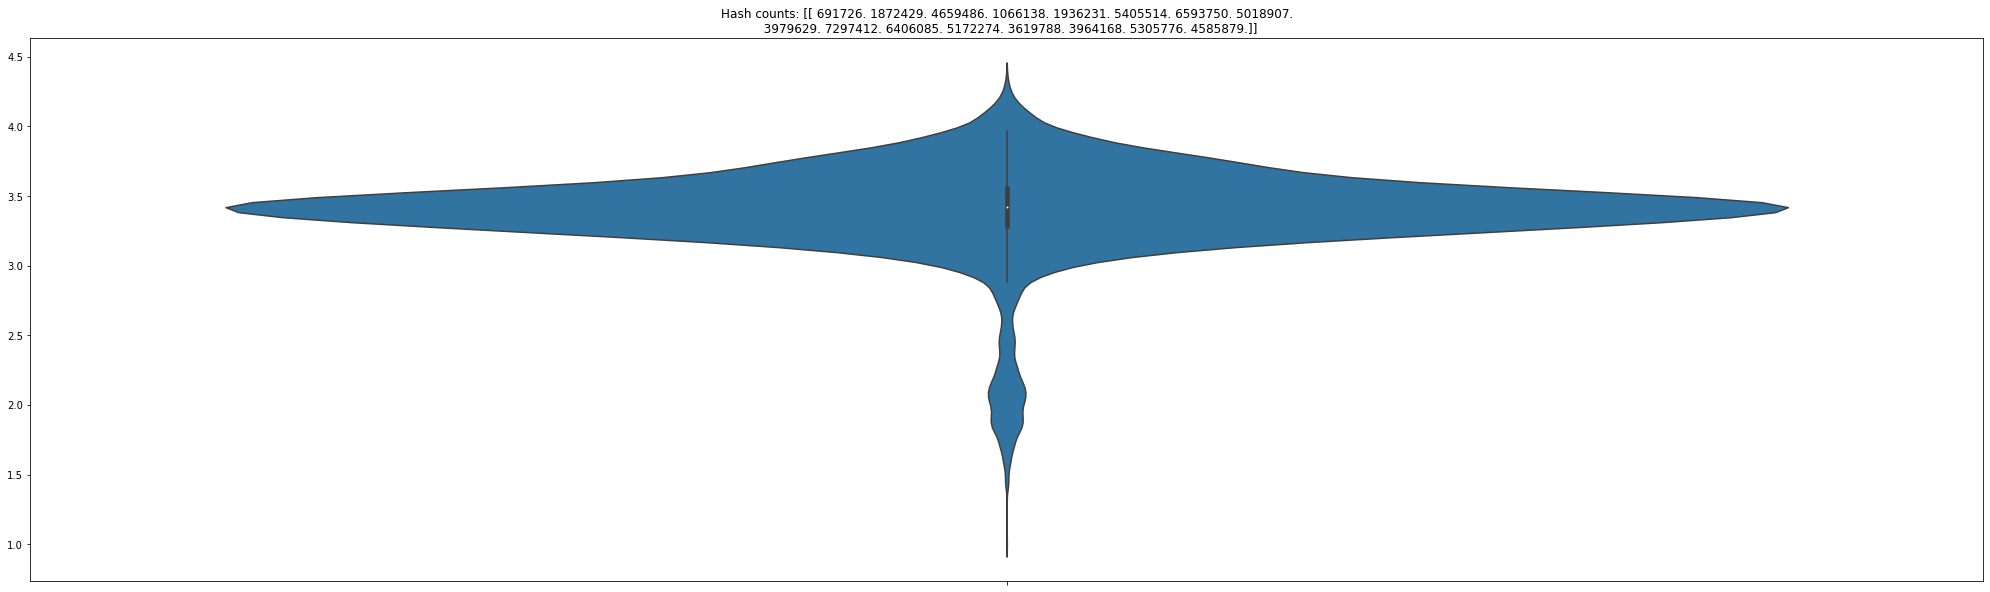

In [6]:
plot, axs = plt.subplots(1, 1, figsize=(35, 10))
sns.violinplot(y=np.log10(adata_hash.X.sum(axis=1)+1), ax=axs)
axs.set_title(f"Hash counts: {adata_hash.X.sum(axis=0)}")

In [8]:
dict_sample_hash = {}
for sample in adata_hash.obs['Sample'].unique():
    if 'WT' in sample:
        dict_sample_hash[sample] = [hashs for hashs in adata_hash.var_names.to_list() if sample in hashs ]
    else: 
        sample_conv = sample[0] + sample[1:].lower()
        dict_sample_hash[sample] = [hashs for hashs in adata_hash.var_names.to_list() if sample_conv in hashs ]


Split Violin plots per sample and related hash. Each Violin plot shows the counts per hash. It is expected to see to separated groups the distinct group at the top represents the cells which are related to the hash

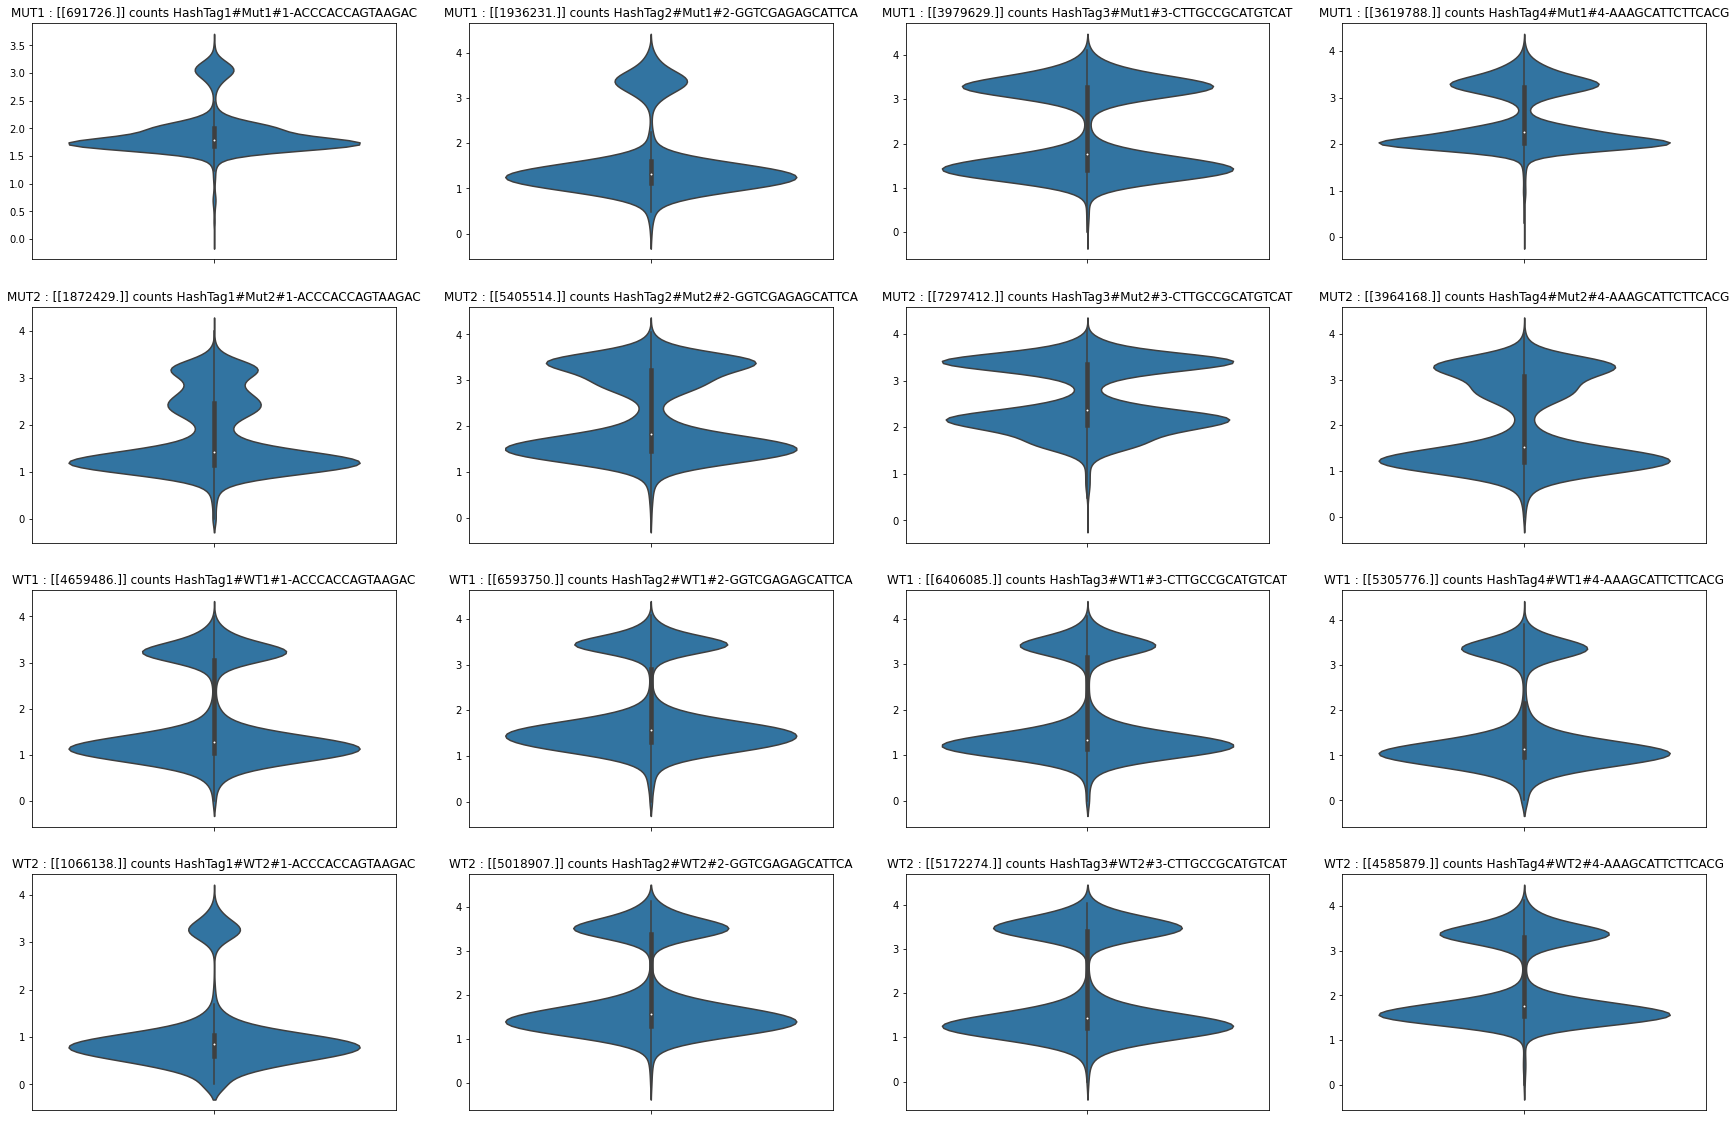

In [11]:
plot, axs = plt.subplots(4, 4, figsize=(30, 20))
axs = axs.flatten()
ax = 0
for sample in adata_hash.obs['Sample'].unique():
    hash_list = dict_sample_hash[sample]
    for hashtag in hash_list:
        sns.violinplot(y=np.log10(adata_hash[adata_hash.obs['Sample'] == sample,hashtag].X.sum(axis=1)+1), ax=axs[ax])
        axs[ax ].set_title(f"{sample} : {adata_hash[:,hashtag].X.sum(axis=0)} counts " + hashtag )
        ax +=1

# Hash Detection
Hash solo predicts three stages for each cell None (cloud not specify hash for cell), singleton (one hash is related to cell) and doublet (a cell is related to two cells). With Priors, you can specify the likelihood for hashsolo to predict a cell for the given stages [negative, singlet, doublet]

In [17]:
from solo import hashsolo

# Run hashsolo
hashsolo.hashsolo(adata_hash,priors=[0.01, 0.7, 0.29])

In [18]:
adata_hash.obs

Sample timepoint batch  most_likely_hypothesis  \
AAACCCACACTCTCGT-MUT1   MUT1      2day     0                       1   
AAACCCATCATTGCCC-MUT1   MUT1      2day     0                       1   
AAACGCTAGAGTTGCG-MUT1   MUT1      2day     0                       1   
AAACGCTAGATCACCT-MUT1   MUT1      2day     0                       1   
AAACGCTAGTGATAGT-MUT1   MUT1      2day     0                       1   
...                      ...       ...   ...                     ...   
TTTGTTGCACGACAGA-WT2     WT2      4day     3                       1   
TTTGTTGGTGGTCCCA-WT2     WT2      4day     3                       1   
TTTGTTGTCATAGCAC-WT2     WT2      4day     3                       1   
TTTGTTGTCGAAGCAG-WT2     WT2      4day     3                       1   
TTTGTTGTCTCCAAGA-WT2     WT2      4day     3                       1   

                       cluster_feature  negative_hypothesis_probability  \
AAACCCACACTCTCGT-MUT1                0                     8.221411e-05   
AAACCCATCATTGCCC-MUT1                0                     2.126045e-08   
AAACGCTAGAGTTGCG-MUT1                0                     4.941882e-19   
AAACGCTAGATCACCT-MUT1                0                     1.452454e-05   
AAACGCTAGTGATAGT-MUT1                0                     5.952962e-19   
...                                ...                              ...   
TTTGTTGCACGACAGA-WT2                 0                     1.300026e-09   
TTTGTTGGTGGTCCCA-WT2                 0                     6.191774e-16   
TTTGTTGTCATAGCAC-WT2                 0                     4.810908e-16   
TTTGTTGTCGAAGCAG-WT2                 0                     1.290003e-09   
TTTGTTGTCTCCAAGA-WT2                 0                     4.838817e-16   

                       singlet_hypothesis_probability  \
AAACCCACACTCTCGT-MUT1                        0.999918   
AAACCCATCATTGCCC-MUT1                        1.000000   
AAACGCTAGAGTTGCG-MUT1                        0.707071   
AAACGCTAGATCACCT-MUT1                        0.999985   
AAACGCTAGTGATAGT-MUT1                        0.707071   
...                                               ...   
TTTGTTGCACGACAGA-WT2                         1.000000   
TTTGTTGGTGGTCCCA-WT2                         1.000000   
TTTGTTGTCATAGCAC-WT2                         1.000000   
TTTGTTGTCGAAGCAG-WT2                         1.000000   
TTTGTTGTCTCCAAGA-WT2                         1.000000   

                       doublet_hypothesis_probability  \
AAACCCACACTCTCGT-MUT1                    3.676083e-13   
AAACCCATCATTGCCC-MUT1                    4.453717e-14   
AAACGCTAGAGTTGCG-MUT1                    2.929293e-01   
AAACGCTAGATCACCT-MUT1                    8.535457e-08   
AAACGCTAGTGATAGT-MUT1                    2.929293e-01   
...                                               ...   
TTTGTTGCACGACAGA-WT2                     8.966006e-14   
TTTGTTGGTGGTCCCA-WT2                     3.522831e-11   
TTTGTTGTCATAGCAC-WT2                     1.364353e-11   
TTTGTTGTCGAAGCAG-WT2                     5.194622e-13   
TTTGTTGTCTCCAAGA-WT2                     1.350446e-10   

                                        Classification  
AAACCCACACTCTCGT-MUT1  HashTag4#Mut1#4-AAAGCATTCTTCACG  
AAACCCATCATTGCCC-MUT1  HashTag4#Mut1#4-AAAGCATTCTTCACG  
AAACGCTAGAGTTGCG-MUT1  HashTag3#Mut1#3-CTTGCCGCATGTCAT  
AAACGCTAGATCACCT-MUT1  HashTag3#Mut1#3-CTTGCCGCATGTCAT  
AAACGCTAGTGATAGT-MUT1  HashTag3#Mut1#3-CTTGCCGCATGTCAT  
...                                                ...  
TTTGTTGCACGACAGA-WT2    HashTag4#WT2#4-AAAGCATTCTTCACG  
TTTGTTGGTGGTCCCA-WT2    HashTag2#WT2#2-GGTCGAGAGCATTCA  
TTTGTTGTCATAGCAC-WT2    HashTag3#WT2#3-CTTGCCGCATGTCAT  
TTTGTTGTCGAAGCAG-WT2    HashTag1#WT2#1-ACCCACCAGTAAGAC  
TTTGTTGTCTCCAAGA-WT2    HashTag3#WT2#3-CTTGCCGCATGTCAT  

[21898 rows x 9 columns]

# Dimensionreduction on hash counts

In [19]:
# Normalize total count per cell to median counts over all cells
scanpy.pp.normalize_total(adata_hash, target_sum = None)

# Stabilize variance by logtransform
scanpy.pp.log1p(adata_hash)

In [20]:
scanpy.pp.neighbors(adata_hash)
# Embed cells into a subspace by UMAP
scanpy.tl.umap(adata_hash, min_dist=0.1, spread=2)

... storing 'Classification' as categorical


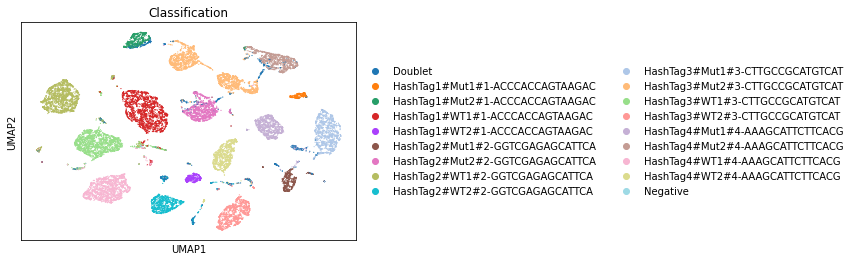

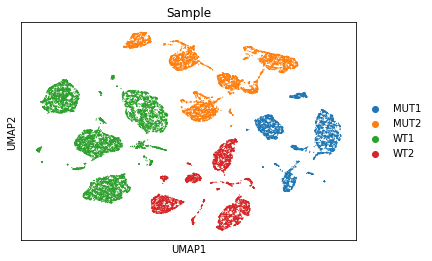

In [21]:
scanpy.pl.umap(adata_hash, color= 'Classification')
scanpy.pl.umap(adata_hash, color= 'Sample')

By looking on the expression of each Hash in the umap the hash detection can be controlled.

/home/pgoyman/.conda/envs/Peak_co_accessibility/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


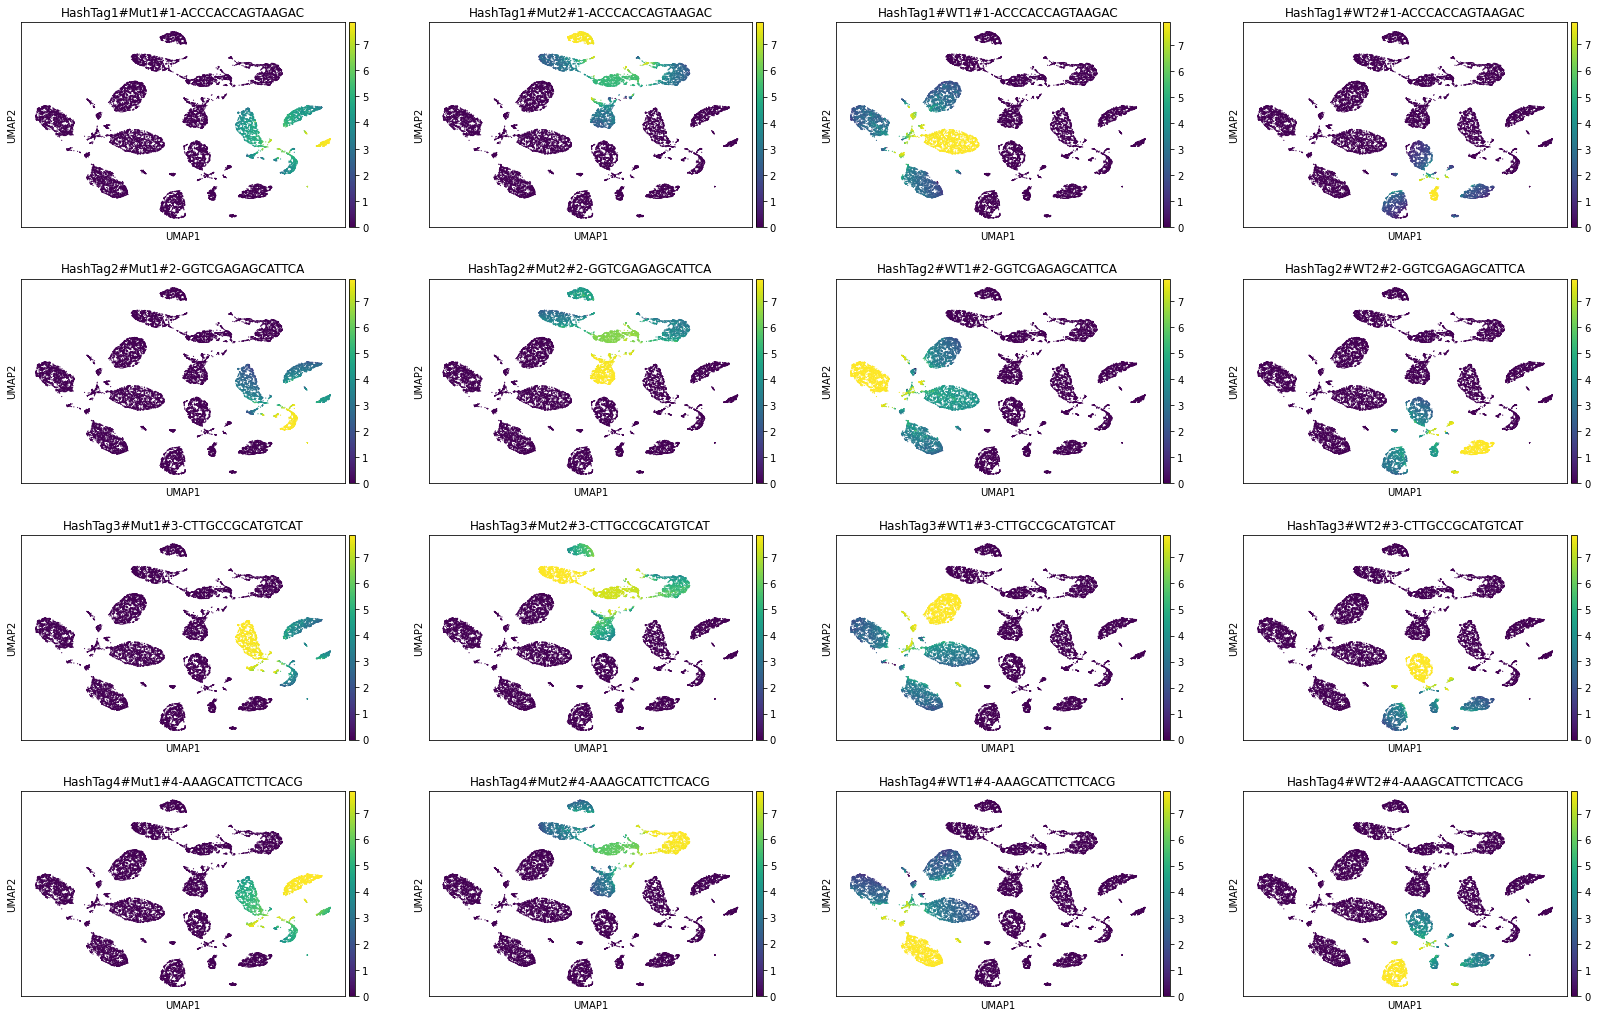

In [588]:
scanpy.pl.umap(adata_hash, color= adata_hash.var.index.to_list())

**Join Back to adata**

As last the classified cells can join back to the adata object with RNA counts by barcode index.

In [ ]:
adata = scanpy.read_h5ad(filename='/mnt/workspace/pgoyman/SC_analysis/poe12/data/adata.h5ad')

In [632]:
adata.obs = pd.merge(adata.obs, adata_hash.obs,  left_index=True, right_index=True, suffixes=('', '_y'),how='outer')
adata.obs.drop(adata.obs.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)